In [140]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import statsmodels.api as sm
import sys
from stocktrends import Renko
import talib
import yfinance as yf
import copy
from alpha_vantage.timeseries import TimeSeries
from collections import OrderedDict
from operator import itemgetter

In [141]:
# !{sys.executable} -m pip install ...

### Tech indicators

In [142]:
def ATR(DF, n):
    df = DF.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
#     df['ATR'] = df['TR'].ewm(span=n, adjust=False, min_periods=n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)
    return df2

In [143]:
def OBV(DF):
    df = DF.copy()
    df['daily return'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily return'] > 0, 1, -1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [144]:
# def slope(DF, n):
#     df  =DF.copy()
#     "function to calc the slope of the consecutive on a plot"
# #     ser = df['Close']/
#     slopes = [i * 0 for i in range(n-1)]
#     for i in range(n, len(ser) + 1):
#         y = ser[i-n:i]
#         x = np.array(range(n))
#         y_scaled = (y - y.min()) / (y.max() - y.min())
#         x_scaled = (x - x.min()) / (x.max() - x.min())
#         x_scaled = sm.add_constant(x_scaled)
#         model = sm.OLS(y_scaled, x_scaled)
#         results = model.fit()
#         slopes.append(results.params[-1])
#     slope_angle = np.rad2deg(np.arctan(np.array(slopes)))
#     return np.array(slope_angle)


def slope(ser,n):
#     df = DF.copy()
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [145]:
def renko_DF(DF):
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:, [0, 1, 2, 3, 4]]
    df.columns = ['date', 'open', 'high', 'low', 'close']
    df2 = Renko(df)
    df2.brick_size = max(0.5, round(ATR(DF, 120)['ATR'][-1], 0))
    renko_df  = df2.get_ohlc_data()
    renko_df['bar_num'] = np.where(renko_df['uptrend'] == True, 1, np.where(renko_df['uptrend'] == False, -1, 0))
    for i in range(1, len(renko_df['bar_num'])):
        if renko_df['bar_num'][i] > 0 and renko_df['bar_num'][i-1] > 0:
            renko_df['bar_num'][i] += renko_df['bar_num'][i-1]
        elif renko_df['bar_num'][i] < 0 and renko_df['bar_num'][i-1] < 0:
            renko_df['bar_num'][i] += renko_df['bar_num'][i-1]
    renko_df.drop_duplicates(subset = 'date', keep='last', inplace=True)
    return renko_df
        

### KPI for the strategy

In [146]:
def CAGR(DF):
    df = DF.copy()
#     df['daily_ret'] = df['close'].pct_change()
    df['cum_ret'] = (1 + df['ret']).cumprod()
#     print(df)
    n = len(df) / (252 * 78)
    CAGR = (df['cum_ret'].tolist()[-1]) ** (1/n) - 1
    return CAGR


def Vola(DF):
    df = DF.copy()
#     df['daily_ret'] = df['close'].pct_change()
    vola = df['ret'].std()
    volatility = vola * np.sqrt(252 * 78)
#     annual_vola = vola * np.sqrt(12)
# #     week_vola = vola * np.sqrt(52)
#     month_vola = vola * np.sqrt(12)
    return volatility


def Sharpe(DF, rf):
    df = DF.copy()
    sr = ((CAGR(df) - rf) / Vola(df))
    return sr


def Sortino(DF, rf):
    df = DF.copy()
    df['ret'] = df['close'].pct_change()
    neg_vola = df[df['ret'] < 0]['ret'].std() * np.sqrt(252 * 78)
    sortino = (CAGR(df) - rf) / neg_vola
    return sortino


def max_dd(DF):
    df = DF.copy()
#     df['mon_ret'] = df['close'].pct_change()
    df['cum_ret'] = (1 + df['ret']).cumprod()
    df['cum_roll_max'] = df['cum_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cum_ret']
    df['drawdown_pct'] = df['drawdown'] / df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd


def Calmar(DF):
    df = DF.copy()
    clmr = CAGR(df) / max_dd(df)
    return clmr 

### Data fetching

##### Bitcoin

In [147]:
# start_date = '20140101'
# # end_date = '20191101'
# end_date = time.strftime("%Y%m%d")

In [148]:
# url ="https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=" + start_date + "&end=" + end_date
# example_df = pd.read_html(url)

# data = example_df[2]
# df =pd.DataFrame(data)

# df['Date'] =  pd.to_datetime(df['Date']) # date
# df.columns = ['Date','Open','High','Low','Close','Volume','Market Cap']
# df.set_index('Date',inplace=True)
# df.sort_index(inplace=True)


##### Stocks

In [149]:
tickers = ['AAPL', 'MMM', 'AMZN', 'MSFT', 'IBM', 'CAT', 'TSLA', 'EW']

start_date_stocks = '2000-01-01'
# end_date = 

In [150]:
ohlc_intraday = {} # to store stock data
key_path = 'IFOZ40XUSKNEY85Z'
ts = TimeSeries(key=key_path, output_format='pandas')
# ts = timeseries(key=open(key_path, 'r').read(), output_format='pandas')

attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store stock whose close price was successfuly extracted

while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] # removing stocks which tiker has been extracted
    for i in range(len(tickers)):
        try:
            ohlc_intraday[tickers[i]] = ts.get_intraday(symbol=tickers[i], interval = '5min', outputsize='full')[0]
            ohlc_intraday[tickers[i]].columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            ohlc_intraday[tickers[i]].sort_index(inplace=True)
            drop.append(tickers[i])
        except:
            print(tickers[i], 'failed to fetch data..retrying')
            continue
    attempt += 1


tickers = ohlc_intraday.keys() #redefine tickers variable after removing any tickers with corrupted data


CAT failed to fetch data..retrying
TSLA failed to fetch data..retrying
EW failed to fetch data..retrying
CAT failed to fetch data..retrying
TSLA failed to fetch data..retrying
EW failed to fetch data..retrying
CAT failed to fetch data..retrying
TSLA failed to fetch data..retrying
EW failed to fetch data..retrying
CAT failed to fetch data..retrying
TSLA failed to fetch data..retrying
EW failed to fetch data..retrying
CAT failed to fetch data..retrying
TSLA failed to fetch data..retrying
EW failed to fetch data..retrying
CAT failed to fetch data..retrying
TSLA failed to fetch data..retrying
EW failed to fetch data..retrying


In [151]:
#Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["obv"]= OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"]= slope(ohlc_renko[ticker]["obv"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

merging for  AAPL


C:\Users\ioshe\Anaconda3\envs\catalyst\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\ioshe\Anaconda3\envs\catalyst\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ioshe\Anaconda3\envs\catalyst\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


merging for  MMM
merging for  AMZN
merging for  MSFT
merging for  IBM


In [152]:
#Identifying signals and calculating daily return
for ticker in tickers:
    print('calculating daily returns for',ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == '':
            tickers_ret[ticker].append(0)
            if ohlc_renko[ticker]['bar_num'][i] >= 2 and ohlc_renko[ticker]['obv_slope'][i] > 30:
                tickers_signal[ticker] = 'Buy'
            elif ohlc_renko[ticker]['bar_num'][i] <= -2 and ohlc_renko[ticker]['obv_slope'][i] < -30:
                tickers_signal[ticker] = 'Sell'
        
        elif tickers_signal[ticker] == 'Buy':
            tickers_ret[ticker].append((ohlc_renko[ticker]['Close'][i] / ohlc_renko[ticker]['Close'][i-1])-1)
            if ohlc_renko[ticker]['bar_num'][i]<=-2 and ohlc_renko[ticker]['obv_slope'][i]<-30:
                tickers_signal[ticker] = 'Sell'
            elif ohlc_renko[ticker]['bar_num'][i]<2:
                tickers_signal[ticker] = ''
                
        elif tickers_signal[ticker] == 'Sell':
            tickers_ret[ticker].append((ohlc_renko[ticker]['Close'][i-1] / ohlc_renko[ticker]['Close'][i])-1)
            if ohlc_renko[ticker]['bar_num'][i] >= 2 and ohlc_renko[ticker]['obv_slope'][i] > 30:
                tickers_signal[ticker] = 'Buy'
            elif ohlc_renko[ticker]['bar_num'][i] >- 2:
                tickers_signal[ticker] = ''
    ohlc_renko[ticker]['ret'] = np.array(tickers_ret[ticker])

calculating daily returns for AAPL
calculating daily returns for MMM
calculating daily returns for AMZN
calculating daily returns for MSFT
calculating daily returns for IBM


In [153]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]['ret']
strategy_df["ret"] = strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(Sharpe(strategy_df,0.02))
print(max_dd(strategy_df))

0.41985874786321276
7.557143712872562
0.009613410709593215


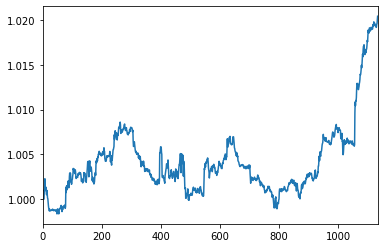

In [154]:
# vizualization of strategy return
(1 + strategy_df['ret']).cumprod().plot();

In [155]:
strategy_df

,AAPL,MMM,AMZN,MSFT,IBM,ret
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...
1130,0.000751,-0.000139,-0.000753,0.000368,0.0,0.000046
1131,0.001246,-0.000258,0.000459,0.000126,0.0,0.000315
1132,0.000450,-0.000310,0.000472,-0.000379,0.0,0.000047
1133,0.000968,-0.001164,0.001671,0.000948,0.0,0.000484


In [156]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  Sharpe(ohlc_renko[ticker],0.05)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  AAPL
calculating KPIs for  MMM
calculating KPIs for  AMZN
calculating KPIs for  MSFT
calculating KPIs for  IBM


,Return,Sharpe Ratio,Max Drawdown
AAPL,1.425490,9.489308,0.028130
MMM,0.317246,1.689847,0.046524
AMZN,0.590158,4.849467,0.020443
MSFT,0.138750,1.047966,0.021783
IBM,-0.032543,-0.847188,0.017040
